In [2]:
import urllib.request
import pandas
import xml.etree.ElementTree as ET

import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import timedelta

# 한글 폰트 설정
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


# 파 가격 예측
## 데이터 로드

In [170]:
def query_sender(date, date_1, last_year, kinds):
    url='http://www.garak.co.kr/publicdata/dataOpen.do?id=2956&passwd=qwert1324!&' \
    'dataid=data4&pagesize=1000&pageidx=1&portal.templet=false&'

    kinds = urllib.parse.quote(kinds)
    code_info='p_ymd=' + date+'&p_jymd='+date_1+'&d_cd=2&p_jjymd='+last_year
    code_info_2='&p_pos_gubun=9&pum_nm='+kinds

    request = urllib.request.Request(url+code_info+code_info_2)
    request.get_method=lambda :'GET'
    response_body=urllib.request.urlopen(request).read()
    u=str(response_body,'utf-8')
    return u



url에서 필요한 데이터를 수집해 오는 것
p_ymd: 검색일자, 8자리
y_jymd: 전일일자, 8자리
c_cd: 부류 구분(청과:2, 수산:3)
p_jjymd: 전년도 날짜, 8자리
p_pos_gubun: 시장구분, 가락시장:1, 양곡시장:2, 강서시장:3(경매), 강서시장:9(시장도매)
pum_nm: 품목명(예: 사과, 배)

In [171]:
def xml_to_item_list(xml_string, date):
    result=[]
    root = ET.fromstring(xml_string)
    for child in root:
        item_list=[]
        item_list.append(date)
        for list in child:
            if list.tag in ['PUM_NM_A', 'AV_P_A', 'PAV_P_A', 'PAV_PY_A', 'E_NAME']:
                item_list.append(list.text)
                #print(list.text)
        result.append(item_list)

    return result

받아온 데이터를 리스트에 저장

한 줄의 정보는 item_list에 저장이 되고 전체 리스트는 result에 저장된다.

In [172]:
flag=False


for date in pandas.date_range(start='20170101', end='20210527'):
    # 반복문으로 하세요를레히후!

    # start와 end로 끝나는 반복문에서 입력타입이 String이므로 스트링으로 바꿔준다.
    # 반복문을 date_range로 한 이유는 숫자형으로 하면 20179999이런 식으로 갈 수 있기 때문이다.
    # date1: 오늘, date2: 전날, date3: 전년도 오늘
    date1 = str(date.strftime("%Y%m%d"))
    #print(date1)
    date2 = str((date-timedelta(days=1)).strftime("%Y%m%d"))
    date3 = str((date-timedelta(days=365)).strftime("%Y%m%d"))
    query=query_sender(date1,
                       date2,
                       date3,
                       '대파')
    #print("쿼리 = \n",query)
    # 함수를 호출한다.
    i_list=xml_to_item_list(query, date1)
    #print("i_list = \n", i_list)
    #display("리스트",i_list)

    df = pd.DataFrame(i_list)
    #df = df.iloc[1:, 1:]

    df=df.drop(df.index[0])
    #display(df)
    # csv파일에 저장할 때 첫번째 열에 column name을 넣어주기 위해 만약 파일이 없으면
    # 첫 번째 파일을 넣어주고 파일이 있으면 그 뒤로는 데이터를 계속 넣어준다.
    if not flag:
        flag = True
        col=['날짜', '품목명', '평균가격', '전일평균가격', '전년가격', '등급']
        df.columns=col
        df.to_csv('./data/test_Gonion.csv',encoding='utf-8-sig')
    else:
        df.to_csv('./data/test_Gonion.csv',encoding='utf-8-sig',mode='a', header=False)

print('끝났다!@@@@@@@@@@@@@@@!!!!!!!!!!!!!!!!!!!!!!@@@@@@@@@@')

끝났다!@@@@@@@@@@@@@@@!!!!!!!!!!!!!!!!!!!!!!@@@@@@@@@@


### 데이터 정제하기

In [173]:
df2 = pd.read_csv('./data/test_Gonion.csv', index_col=0)
display(df2)

dfw = pd.read_csv('./data/weather.csv', encoding='CP949')
display(dfw)

,날짜,품목명,평균가격,전일평균가격,전년가격,등급
1,20170101,대파(일반),0.0,2833.0,0.0,특
2,20170101,대파(일반),0.0,2164.0,0.0,상
3,20170101,대파(일반),0.0,1747.0,0.0,중
4,20170101,대파(일반),0.0,1214.0,0.0,하
1,20170102,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4,20210526,대파(일반),1180.0,1392.0,1208.0,하
1,20210527,대파(일반),3699.0,3601.0,1952.0,특
2,20210527,대파(일반),1554.0,2152.0,1639.0,상
3,20210527,대파(일반),1247.0,1572.0,1500.0,중


,지점,지점명,일시,평균기온(°C),일강수량(mm),일 최심신적설(cm)
0,268,진도군,20170101,4.3,NaN,NaN
1,268,진도군,20170102,8.1,0.0,NaN
2,268,진도군,20170103,5.1,NaN,NaN
3,268,진도군,20170104,4.4,NaN,NaN
4,268,진도군,20170105,7.5,0.5,NaN
...,...,...,...,...,...,...
1590,268,진도군,20210523,19.7,0.0,NaN
1591,268,진도군,20210524,17.6,0.0,NaN
1592,268,진도군,20210525,17.3,NaN,NaN
1593,268,진도군,20210526,17.1,0.7,NaN


In [174]:
# 날씨 데이터의 NaN 값을 0으로 바꿔준다.
dfw=dfw.fillna(0)

In [175]:
# 인덱스 12341234 되어 있는걸 바꿔줌
index = range(df2.shape[0])
df2.index = index
display(df2)

,날짜,품목명,평균가격,전일평균가격,전년가격,등급
0,20170101,대파(일반),0.0,2833.0,0.0,특
1,20170101,대파(일반),0.0,2164.0,0.0,상
2,20170101,대파(일반),0.0,1747.0,0.0,중
3,20170101,대파(일반),0.0,1214.0,0.0,하
4,20170102,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
6385,20210526,대파(일반),1180.0,1392.0,1208.0,하
6386,20210527,대파(일반),3699.0,3601.0,1952.0,특
6387,20210527,대파(일반),1554.0,2152.0,1639.0,상
6388,20210527,대파(일반),1247.0,1572.0,1500.0,중


In [176]:
# 날씨 데이터와 파 가격 데이터를 한 데이터프레임으로 만드는 과정
# 데이터프레임에 리스트를 붙이려면 한 열이 완전하게 만들어져 있어야됨
# 한 열을 리스트로 만드는 작업
temp_list = []
rain_list = []
day_list = []
count = 0

for i1 in df2.index:
    for i2 in dfw.index:
        if df2['날짜'][i1] != dfw['일시'][i2]:
            continue
        temp_list.append(dfw['평균기온(°C)'][i2])
        rain_list.append(dfw['일강수량(mm)'][i2])
        day_list.append(dfw['일시'][i2])
        count +=1


print('temp_list', temp_list)
print(len(temp_list))
print('rain_list', rain_list)
print(len(rain_list))

temp_list [4.3, 4.3, 4.3, 4.3, 8.1, 5.1, 5.1, 5.1, 5.1, 4.4, 4.4, 4.4, 4.4, 7.5, 7.5, 7.5, 7.5, 7.2, 7.2, 7.2, 7.2, 7.1, 7.1, 7.1, 7.1, 8.1, 5.6, 5.6, 5.6, 5.6, 4.2, 4.2, 4.2, 4.2, 1.9, 1.9, 1.9, 1.9, 3.7, 3.7, 3.7, 3.7, 3.1, 3.1, 3.1, 3.1, 0.1, 0.1, 0.1, 0.1, -0.5, 1.8, 1.8, 1.8, 1.8, 0.8, 0.8, 0.8, 0.8, 3.5, 3.5, 3.5, 3.5, 2.5, 2.5, 2.5, 2.5, 0.8, 0.8, 0.8, 0.8, 1.9, 1.9, 1.9, 1.9, 0.2, -0.5, -0.5, -0.5, -0.5, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.3, 1.3, 1.3, 1.3, 3.1, 3.1, 3.1, 3.1, 3.9, 3.9, 3.9, 3.9, 8.8, 1.2, -0.4, -0.4, -0.4, -0.4, 1.8, 1.8, 1.8, 1.8, 0.9, 0.9, 0.9, 0.9, 1.7, 1.7, 1.7, 1.7, 6.9, 6.9, 6.9, 6.9, 6.2, 2.9, 2.9, 2.9, 2.9, 2.4, 2.4, 2.4, 2.4, 2.6, 2.6, 2.6, 2.6, 0.0, 0.0, 0.0, 0.0, -1.5, -1.5, -1.5, -1.5, 0.2, 0.2, 0.2, 0.2, 1.7, 2.9, 2.9, 2.9, 2.9, 3.8, 3.8, 3.8, 3.8, 2.1, 2.1, 2.1, 2.1, 8.5, 8.5, 8.5, 8.5, 5.1, 5.1, 5.1, 5.1, 0.7, 0.7, 0.7, 0.7, 6.0, 3.8, 3.8, 3.8, 3.8, 3.2, 3.2, 3.2, 3.2, 8.1, 8.1, 8.1, 8.1, 2.6, 2.6, 2.6, 2.6, 1.6, 1.6, 1.6, 1.6, 4.0, 4.0, 4

In [177]:
# 바로 위에 보면 열이 6390개인데 여기서는 6338개가 나옴!
# 바로 데이터 확인 함(차집합 이용)
dd=np.array(df2['날짜'].tolist())
dl=np.array(day_list)
intersection = np.array(list(set(dd)-set(dl)))
print(intersection)
print(len(intersection))

# 13*4 해서 누락된 52개의 데이터를 확인함.
# 엑셀로 확인해 보니 저 날씨 데이터가 누락되어있었음

[20170720 20170721 20170722 20190529 20191202 20191017 20191018 20171116
 20171221 20171222 20171031 20171130 20200702]
13


In [178]:
# 기상청 기록이 13개가 없던 것
# 그래서 리스트에 매핑하려고 했는데 수가 없어가지고 아마 오류가 났을것이다.
#누락된 52개 데이터 삭제
tf=[]

for i in df2.index:
    if df2['날짜'][i] in intersection:
        df2= df2.drop(index=i, axis=0)

# df2를 df22로 옮기기
df22= df2.copy()
# 누락된 데이터가 잘 삭제되었는지 확인
print(len(df22.index))

6338


In [179]:
# df22에 데이터를 붙여주기
df22['평균기온'] = temp_list
df22['강수량'] = rain_list
display(df22)

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
0,20170101,대파(일반),0.0,2833.0,0.0,특,4.3,0.0
1,20170101,대파(일반),0.0,2164.0,0.0,상,4.3,0.0
2,20170101,대파(일반),0.0,1747.0,0.0,중,4.3,0.0
3,20170101,대파(일반),0.0,1214.0,0.0,하,4.3,0.0
4,20170102,NaN,NaN,NaN,NaN,NaN,8.1,0.0
...,...,...,...,...,...,...,...,...
6385,20210526,대파(일반),1180.0,1392.0,1208.0,하,17.1,0.7
6386,20210527,대파(일반),3699.0,3601.0,1952.0,특,16.9,0.6
6387,20210527,대파(일반),1554.0,2152.0,1639.0,상,16.9,0.6
6388,20210527,대파(일반),1247.0,1572.0,1500.0,중,16.9,0.6


### EDA

In [180]:
df22.shape

(6338, 8)

In [181]:
# 누락된 데이터 삭제
# 대파 데이터에서 누락된 데이터 삭제, 대파 데이터에는 누락값이 2가지가 있음
# 0원으로 기록된 것과 NaN값으로 아예 아무 데이터도 없는 것.
# NaN값은 그 전가격 아무것도 없기 때문에 삭제해 주기로 함.
df22.isna().sum()

날짜         0
품목명       14
평균가격      14
전일평균가격    14
전년가격      14
등급        14
평균기온       0
강수량        0
dtype: int64

In [182]:
df22 = df22.dropna()
display(df22)

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
0,20170101,대파(일반),0.0,2833.0,0.0,특,4.3,0.0
1,20170101,대파(일반),0.0,2164.0,0.0,상,4.3,0.0
2,20170101,대파(일반),0.0,1747.0,0.0,중,4.3,0.0
3,20170101,대파(일반),0.0,1214.0,0.0,하,4.3,0.0
5,20170103,대파(일반),2833.0,0.0,2761.0,특,5.1,0.0
...,...,...,...,...,...,...,...,...
6385,20210526,대파(일반),1180.0,1392.0,1208.0,하,17.1,0.7
6386,20210527,대파(일반),3699.0,3601.0,1952.0,특,16.9,0.6
6387,20210527,대파(일반),1554.0,2152.0,1639.0,상,16.9,0.6
6388,20210527,대파(일반),1247.0,1572.0,1500.0,중,16.9,0.6


#### 데이터 파악

In [183]:
# 데이터 정보 확인
df22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6324 entries, 0 to 6389
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      6324 non-null   int64  
 1   품목명     6324 non-null   object 
 2   평균가격    6324 non-null   float64
 3   전일평균가격  6324 non-null   float64
 4   전년가격    6324 non-null   float64
 5   등급      6324 non-null   object 
 6   평균기온    6324 non-null   float64
 7   강수량     6324 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 444.7+ KB


In [184]:
df22.describe()

,날짜,평균가격,전일평균가격,전년가격,평균기온,강수량
count,6.324000e+03,6324.000000,6324.000000,6324.000000,6324.000000,6324.000000
mean,2.018813e+07,1581.423941,1582.323371,1334.657337,13.753574,3.705187
std,1.277048e+04,1106.623326,1105.753259,857.593694,8.481000,15.402556
min,2.017010e+07,0.000000,0.000000,0.000000,-8.200000,0.000000
25%,2.018022e+07,946.000000,946.750000,866.000000,6.700000,0.000000
50%,2.019032e+07,1423.000000,1425.000000,1329.500000,13.700000,0.000000
75%,2.020043e+07,2072.500000,2074.000000,1862.000000,21.000000,0.400000
max,2.021053e+07,10749.000000,10749.000000,10749.000000,29.500000,305.000000


##### 등급별로 그룹

In [185]:
# 가격 데이터를 보면 하루에 특, 상, 중, 하 4개로 나누어져 있으므로,
# 이 4개의 데이터가 섞이지 않도록 하기 위해 groupby로 등급별로 나눠준다.
print('## groupby (등급) ##')
grouped = df22.groupby('등급')

#그룹 확인
for name, group in grouped:
    print('groupname: ', name)
    print('groupdata')
    print(group)

#그룹 추출
adf = grouped.get_group(name='특')
bdf = grouped.get_group(name='상')
cdf = grouped.get_group(name='중')
ddf = grouped.get_group(name='하')

## groupby (등급) ##
groupname:  상
groupdata
            날짜     품목명    평균가격  전일평균가격    전년가격 등급  평균기온  강수량
1     20170101  대파(일반)     0.0  2164.0     0.0  상   4.3  0.0
6     20170103  대파(일반)  2164.0     0.0  1926.0  상   5.1  0.0
10    20170104  대파(일반)  2100.0  2164.0  2126.0  상   4.4  0.0
14    20170105  대파(일반)  2100.0  2100.0  1848.0  상   7.5  0.5
18    20170106  대파(일반)  2100.0  2100.0  1865.0  상   7.2  0.2
...        ...     ...     ...     ...     ... ..   ...  ...
6371  20210523  대파(일반)     0.0  1883.0  1546.0  상  19.7  0.0
6375  20210524  대파(일반)  1804.0     0.0     0.0  상  17.6  0.0
6379  20210525  대파(일반)  2153.0  1804.0  1614.0  상  17.3  0.0
6383  20210526  대파(일반)  2152.0  2153.0  1623.0  상  17.1  0.7
6387  20210527  대파(일반)  1554.0  2152.0  1639.0  상  16.9  0.6

[1581 rows x 8 columns]
groupname:  중
groupdata
            날짜     품목명    평균가격  전일평균가격    전년가격 등급  평균기온  강수량
2     20170101  대파(일반)     0.0  1747.0     0.0  중   4.3  0.0
7     20170103  대파(일반)  1747.0     0.0  1611.0  중   5.

In [186]:
# 기초 통계량
print('특 가격 통계\n', adf['평균가격'].describe(), '\n')
print('상 가격 통계\n', bdf['평균가격'].describe(), '\n')
print('중 가격 통계\n', cdf['평균가격'].describe(), '\n')
print('하 가격 통계\n', ddf['평균가격'].describe(), '\n')



특 가격 통계
 count     1581.000000
mean      2187.337128
std       1296.669209
min          0.000000
25%       1600.000000
50%       2141.000000
75%       2699.000000
max      10749.000000
Name: 평균가격, dtype: float64 

상 가격 통계
 count    1581.000000
mean     1688.550917
std      1040.067714
min         0.000000
25%      1217.000000
50%      1581.000000
75%      2093.000000
max      5788.000000
Name: 평균가격, dtype: float64 

중 가격 통계
 count    1581.000000
mean     1356.450980
std       907.954596
min         0.000000
25%       960.000000
50%      1233.000000
75%      1639.000000
max      5254.000000
Name: 평균가격, dtype: float64 

하 가격 통계
 count    1581.000000
mean     1093.356736
std       803.405687
min         0.000000
25%       734.000000
50%       953.000000
75%      1322.000000
max      4929.000000
Name: 평균가격, dtype: float64 



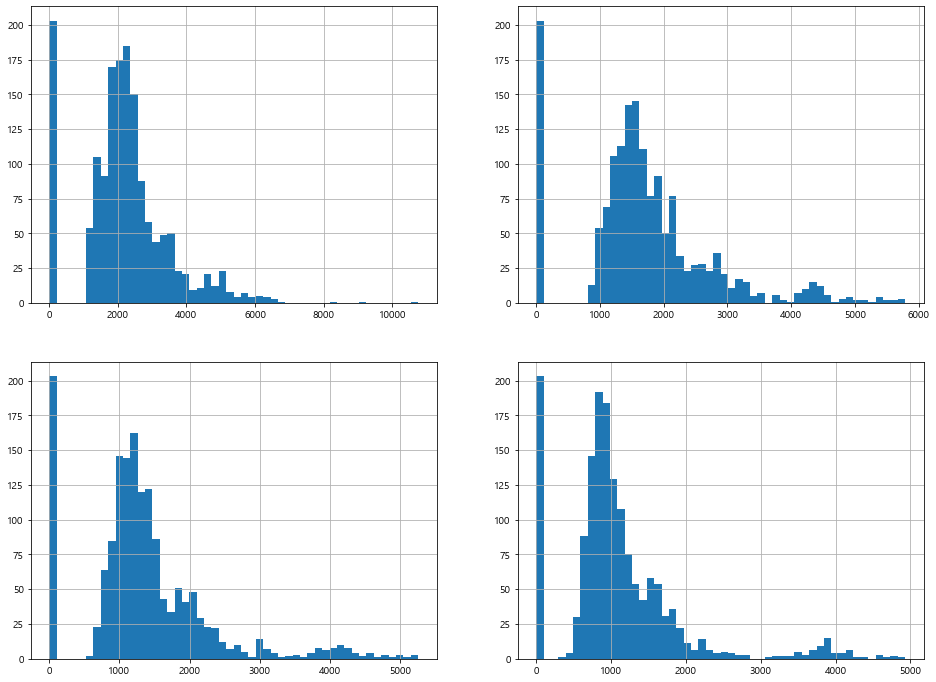

In [187]:
# 분포
def plot_price (l1,l2,l3, l4):
    plt.figure(figsize=(16,12))
    plt.subplot(221)
    l1['평균가격'].hist(bins=50)
    plt.subplot(222)
    l2['평균가격'].hist(bins=50)
    plt.subplot(223)
    l3['평균가격'].hist(bins=50)
    plt.subplot(224)
    l4['평균가격'].hist(bins=50)

plot_price(adf, bdf,cdf,ddf)
# 데이터를 보면 0이 엄청 많은 것을 확인할 수 있음... 0 삭제

In [188]:
# 가격 데이터가 없는 곳에는 0이라 되어 있으므로 0 -> NaN
# 나눈 상태에서 NaN 값에 평균을 넣어 줘야 하는구나,,,
def zeroToNaN (list):
    list['평균가격'] = list['평균가격'].replace(0, np.NaN)
    display('평균가격 0.0 -> NaN',list.head())

    list = list.fillna(list.mean())
    list = list.round(1)
    display('평균가격 NaN -> 열의 평균',list.head())
    return list


adf = zeroToNaN(adf)
bdf = zeroToNaN(bdf)
cdf = zeroToNaN(cdf)
ddf = zeroToNaN(ddf)

c:\201814471\setup\envs\py37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


'평균가격 0.0 -> NaN'

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
0,20170101,대파(일반),NaN,2833.0,0.0,특,4.3,0.0
5,20170103,대파(일반),2833.0,0.0,2761.0,특,5.1,0.0
9,20170104,대파(일반),2797.0,2833.0,2957.0,특,4.4,0.0
13,20170105,대파(일반),2797.0,2797.0,2621.0,특,7.5,0.5
17,20170106,대파(일반),2797.0,2797.0,2599.0,특,7.2,0.2


'평균가격 NaN -> 열의 평균'

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
0,20170101,대파(일반),2509.6,2833.0,0.0,특,4.3,0.0
5,20170103,대파(일반),2833.0,0.0,2761.0,특,5.1,0.0
9,20170104,대파(일반),2797.0,2833.0,2957.0,특,4.4,0.0
13,20170105,대파(일반),2797.0,2797.0,2621.0,특,7.5,0.5
17,20170106,대파(일반),2797.0,2797.0,2599.0,특,7.2,0.2


c:\201814471\setup\envs\py37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


'평균가격 0.0 -> NaN'

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
1,20170101,대파(일반),NaN,2164.0,0.0,상,4.3,0.0
6,20170103,대파(일반),2164.0,0.0,1926.0,상,5.1,0.0
10,20170104,대파(일반),2100.0,2164.0,2126.0,상,4.4,0.0
14,20170105,대파(일반),2100.0,2100.0,1848.0,상,7.5,0.5
18,20170106,대파(일반),2100.0,2100.0,1865.0,상,7.2,0.2


'평균가격 NaN -> 열의 평균'

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
1,20170101,대파(일반),1937.3,2164.0,0.0,상,4.3,0.0
6,20170103,대파(일반),2164.0,0.0,1926.0,상,5.1,0.0
10,20170104,대파(일반),2100.0,2164.0,2126.0,상,4.4,0.0
14,20170105,대파(일반),2100.0,2100.0,1848.0,상,7.5,0.5
18,20170106,대파(일반),2100.0,2100.0,1865.0,상,7.2,0.2


c:\201814471\setup\envs\py37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


'평균가격 0.0 -> NaN'

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
2,20170101,대파(일반),NaN,1747.0,0.0,중,4.3,0.0
7,20170103,대파(일반),1747.0,0.0,1611.0,중,5.1,0.0
11,20170104,대파(일반),2000.0,1747.0,1797.0,중,4.4,0.0
15,20170105,대파(일반),2000.0,2000.0,1707.0,중,7.5,0.5
19,20170106,대파(일반),2000.0,2000.0,1566.0,중,7.2,0.2


'평균가격 NaN -> 열의 평균'

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
2,20170101,대파(일반),1556.3,1747.0,0.0,중,4.3,0.0
7,20170103,대파(일반),1747.0,0.0,1611.0,중,5.1,0.0
11,20170104,대파(일반),2000.0,1747.0,1797.0,중,4.4,0.0
15,20170105,대파(일반),2000.0,2000.0,1707.0,중,7.5,0.5
19,20170106,대파(일반),2000.0,2000.0,1566.0,중,7.2,0.2


c:\201814471\setup\envs\py37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


'평균가격 0.0 -> NaN'

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
3,20170101,대파(일반),NaN,1214.0,0.0,하,4.3,0.0
8,20170103,대파(일반),1214.0,0.0,1434.0,하,5.1,0.0
12,20170104,대파(일반),1838.0,1214.0,1532.0,하,4.4,0.0
16,20170105,대파(일반),1838.0,1838.0,1498.0,하,7.5,0.5
20,20170106,대파(일반),1838.0,1838.0,1419.0,하,7.2,0.2


'평균가격 NaN -> 열의 평균'

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
3,20170101,대파(일반),1254.4,1214.0,0.0,하,4.3,0.0
8,20170103,대파(일반),1214.0,0.0,1434.0,하,5.1,0.0
12,20170104,대파(일반),1838.0,1214.0,1532.0,하,4.4,0.0
16,20170105,대파(일반),1838.0,1838.0,1498.0,하,7.5,0.5
20,20170106,대파(일반),1838.0,1838.0,1419.0,하,7.2,0.2


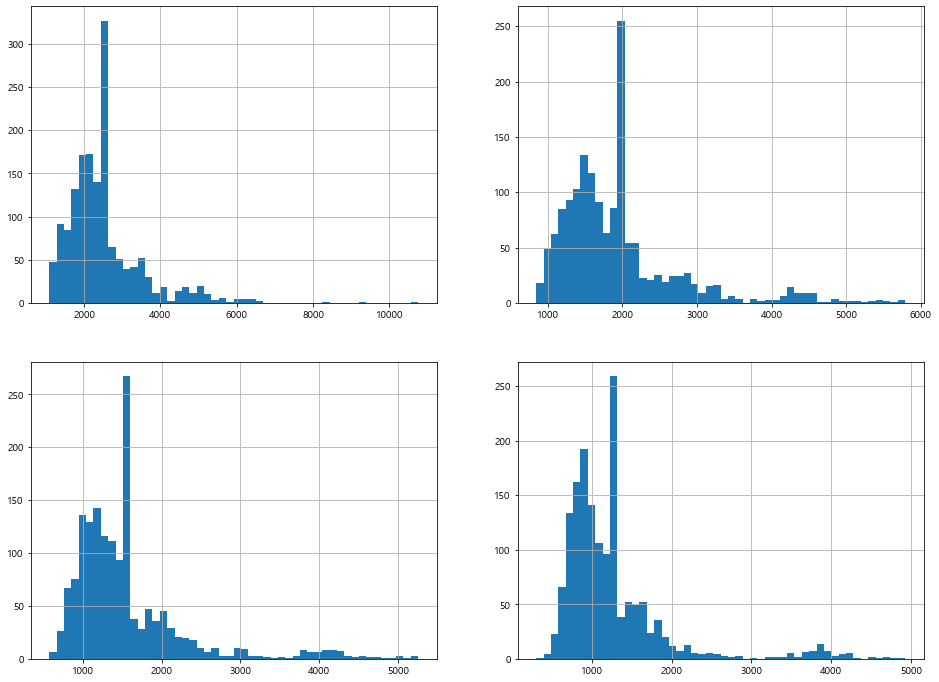

In [189]:
# 위의 셀 실행하고 더 위로 올라가서 다시 groupby해서 다시 실행함.
plot_price(adf, bdf,cdf,ddf)

In [190]:
# 데이터를 계속 정제하는 수고로움을 막기 위해 정제하고 나는 특 데이터를 csv 파일로 저장해둠
# 모델링할 때 바로 계속계속 쓰기 위해서
adf.to_csv('./data/best.csv',encoding = 'utf-8-sig' )
bdf.to_csv('./data/good.csv',encoding = 'utf-8-sig')
cdf.to_csv('./data/average.csv',encoding = 'utf-8-sig')
ddf.to_csv('./data/bad.csv',encoding = 'utf-8-sig')

In [3]:
# 상 데이터만 먼저 사용
adf = pd.read_csv('./data/best.csv', index_col = 0)
display(adf.head())


,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
0,20170101,대파(일반),2509.6,2833.0,0.0,특,4.3,0.0
5,20170103,대파(일반),2833.0,0.0,2761.0,특,5.1,0.0
9,20170104,대파(일반),2797.0,2833.0,2957.0,특,4.4,0.0
13,20170105,대파(일반),2797.0,2797.0,2621.0,특,7.5,0.5
17,20170106,대파(일반),2797.0,2797.0,2599.0,특,7.2,0.2


<AxesSubplot:>

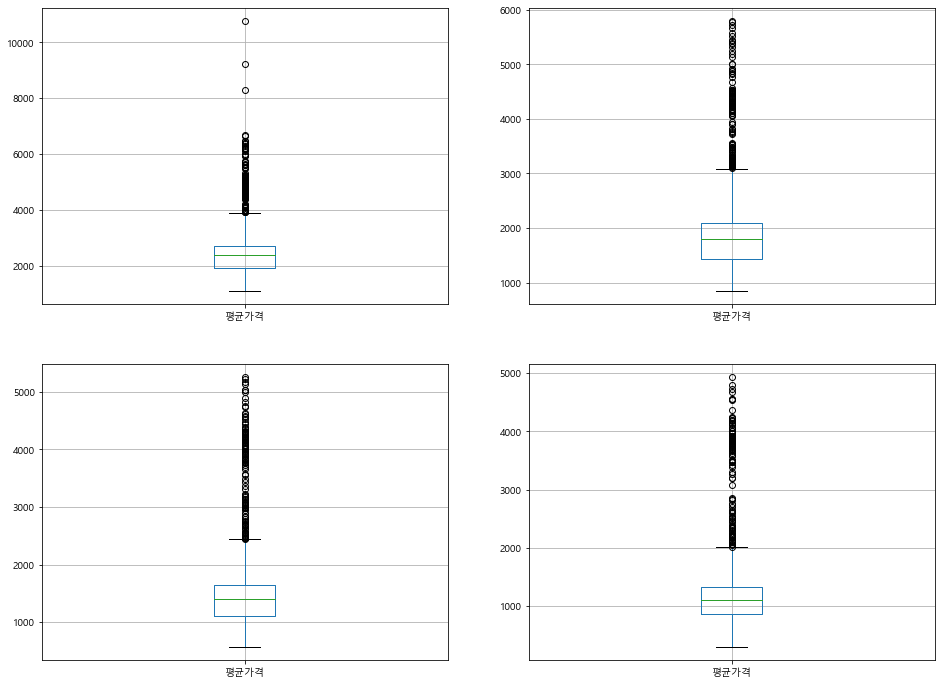

In [192]:
# 데이터 해석: 초록선-중앙값, 네모-1~3사분위수, 선끝-최대, 최소, 동그라미 최대최소 나가는거
# 동그라미가 왜이렇게 많냐면 그래프 작게 그리고 데이터는 많아가지고 이렇게 나오는거 대부분은 박스 안에
# 있음
plt.figure(figsize=(16,12))
plt.subplot(221)
adf.boxplot(column=['평균가격'])
plt.subplot(222)
bdf.boxplot(column=['평균가격'])
plt.subplot(223)
cdf.boxplot(column=['평균가격'])
plt.subplot(224)
ddf.boxplot(column=['평균가격'])

c:\201814471\setup\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


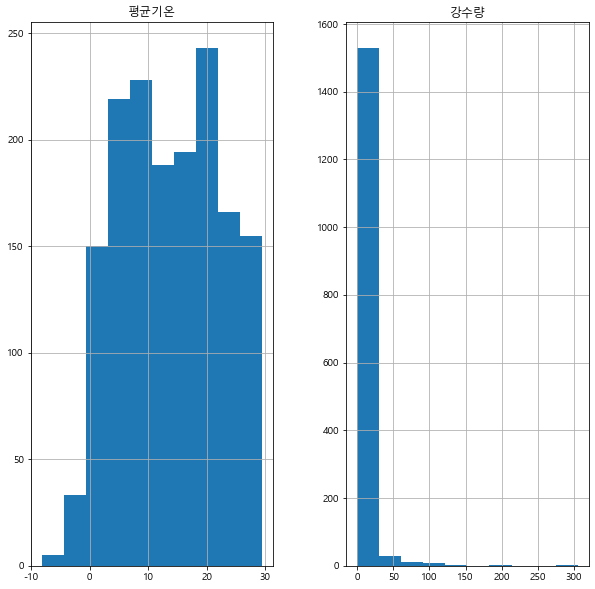

In [193]:
# 입력변수 탐색
check_columns = ['평균기온', '강수량']

fig=plt.figure(figsize=(10, 10))
ax = fig.gca()

# 4개 다 똑같으니까 하나만 봐도 되겠지?
adf[check_columns].hist(ax=ax)
plt.rc('axes', unicode_minus=False)
plt.show()

#이 데이터를 보면 평균 기온은 이렇게 분포가 되어 있고, 강수량을 보니 비가 안올 때 데이터가 많음

In [194]:
# Person 상관계수
check_columns = ['평균가격','평균기온', '강수량']

corr = adf[check_columns].corr(method='pearson')
corr

# 큰일났다 둘다 0에 가깝다: 변수 사이에 선형 관계가 없다
# ... 제대로 안나올 것 같다.

,평균가격,평균기온,강수량
평균가격,1.00000,-0.091170,0.019380
평균기온,-0.09117,1.000000,0.154197
강수량,0.01938,0.154197,1.000000


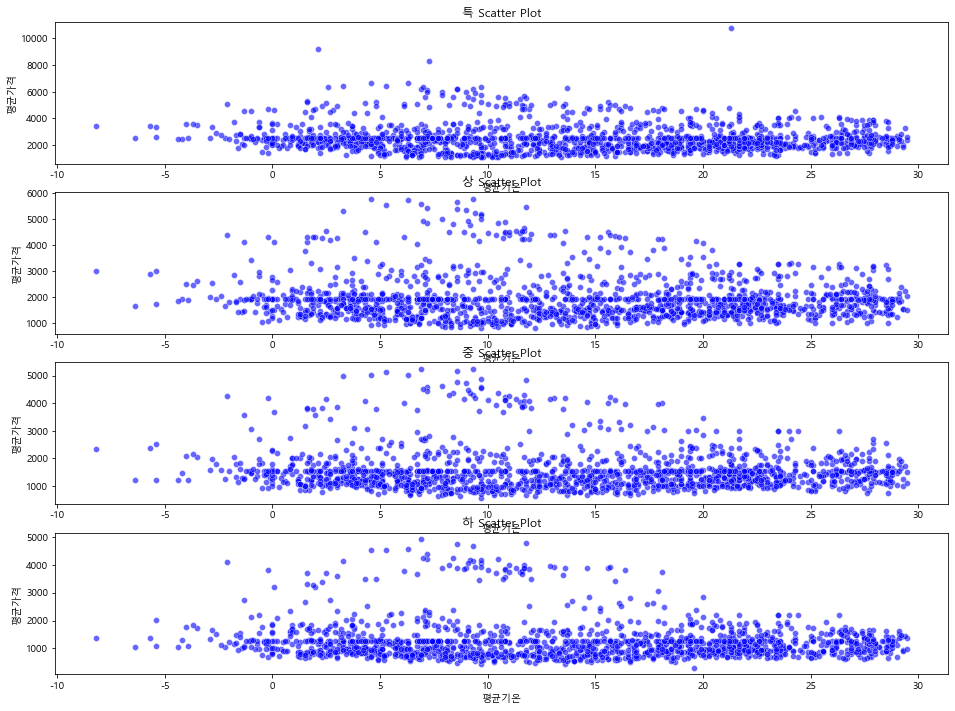

In [195]:
# 평균 기온과 평균 가격 사이의 관계 확인
def plot_scatter(l1, l2, l3, l4,input1,input2):
    plt.figure(figsize=(16,12))
    plt.subplot(411)
    sns.scatterplot(data=l1, x=input1, y=input2, markers='o',
                    color='blue', alpha=0.6)
    plt.title('특 Scatter Plot')
    plt.subplot(412)

    sns.scatterplot(data=l2, x=input1, y=input2, markers='o',
                    color='blue', alpha=0.6)
    plt.title('상 Scatter Plot')
    plt.subplot(413)

    sns.scatterplot(data=l3, x=input1, y=input2, markers='o',
                    color='blue', alpha=0.6)
    plt.title('중 Scatter Plot')
    plt.subplot(414)
    sns.scatterplot(data=l4, x=input1, y=input2, markers='o',
                    color='blue', alpha=0.6)
    plt.title('하 Scatter Plot')
    plt.show()



plot_scatter(adf, bdf, cdf, ddf, '평균기온', '평균가격')


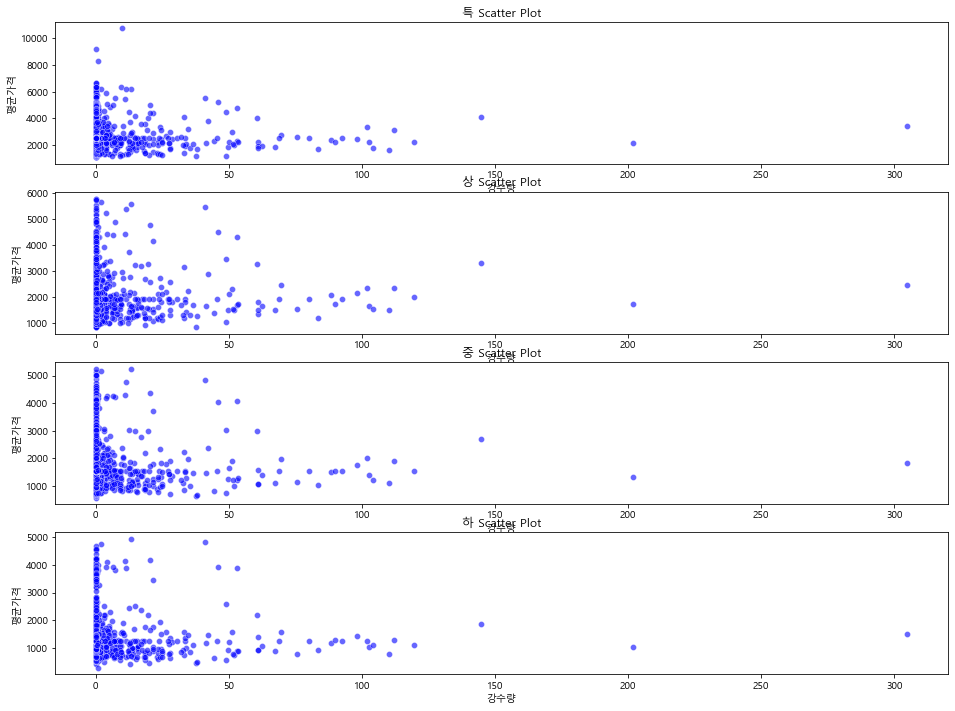

In [196]:
# 강수량 과 평균가격 사이의 관계 확인
plot_scatter(adf,bdf,cdf,ddf,'강수량', '평균가격')


# 비가 많이오든...날이 춥던 덥든...비슷하고 특별하게 가격이 튀는 날이 얼마 없네,,
# 일단 선형회귀를 한번 돌려봄 혹시 모르니까, 근데 시계열 모델을 사용할 마음의 준비는 하고 있었음


### 선형회귀 모델링

In [197]:
from sklearn.model_selection import train_test_split
check_columns = ['평균기온', '강수량']
X = adf[check_columns]
y = adf['평균가격']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [198]:
X_train.shape, y_train.shape

((1264, 2), (1264,))

In [199]:
X_test.shape, y_test.shape


((317, 2), (317,))

In [200]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

pred_test = lr.predict(X_test)

In [201]:
print(lr.coef_)

[-10.72476776   1.94758294]


In [202]:
# 성능 평가
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
#ㅋㅋㅋㅋ 그래,, 앞에서 데이터 확인해볼때 부터 알아봤다,,,
# 1이랑 하나도 안가까움ㅋㅋㅋ

0.008609597546200942
0.009087999164732796


In [203]:
test = {'평균기온':[25, 40, 0, -10],
        '강수량':[26, 0, 0, 70]}
testdf= pd.DataFrame(test)
display(testdf)
print(lr.predict(testdf))

#그래도 가격이 예측되긴 함, 결과를 보면 날이 좋으면 싸고, 춥고 비가 온 날은 가격이 비쌈

,평균기온,강수량
0,25,26
1,40,0
2,0,0
3,-10,70


[2418.46731734 2206.95864434 2635.9493549  2879.52783862]


### LSTM 모델링

In [4]:
# 굳이 csv로 저장 하지 않아도 되지만, 여러번 실험하기 위해 계속 데이터를 불러와서
# 자르고 나누고 하는 것 보다 정제된 데이터를 저장해야 겠다 생각하여 상 데이터를 저장해놓은
# best.csv 파일이다.
df = adf.copy()

df['날짜'] = df['날짜'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df = df.set_index('날짜')

display(df)

,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
날짜,,,,,,,
2017-01-01,대파(일반),2509.6,2833.0,0.0,특,4.3,0.0
2017-01-03,대파(일반),2833.0,0.0,2761.0,특,5.1,0.0
2017-01-04,대파(일반),2797.0,2833.0,2957.0,특,4.4,0.0
2017-01-05,대파(일반),2797.0,2797.0,2621.0,특,7.5,0.5
2017-01-06,대파(일반),2797.0,2797.0,2599.0,특,7.2,0.2
...,...,...,...,...,...,...,...
2021-05-23,대파(일반),2509.6,3364.0,1668.0,특,19.7,0.0
2021-05-24,대파(일반),3047.0,0.0,0.0,특,17.6,0.0
2021-05-25,대파(일반),3662.0,3047.0,1900.0,특,17.3,0.0


In [19]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.unicode_minus'] = False



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1581 entries, 2017-01-01 to 2021-05-27
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   품목명     1581 non-null   object 
 1   평균가격    1581 non-null   float64
 2   전일평균가격  1581 non-null   float64
 3   전년가격    1581 non-null   float64
 4   등급      1581 non-null   object 
 5   평균기온    1581 non-null   float64
 6   강수량     1581 non-null   float64
dtypes: float64(5), object(2)
memory usage: 98.8+ KB


<AxesSubplot:xlabel='날짜'>

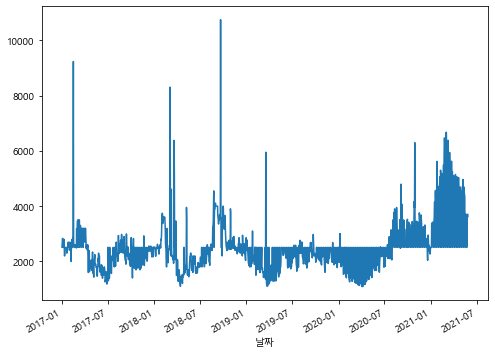

In [7]:
plt.rc('font', family='Malgun Gothic')
df['평균가격'].plot()

<AxesSubplot:xlabel='날짜'>

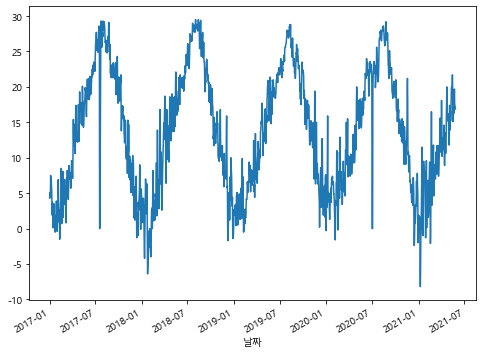

In [8]:
plt.rc('font', family='Malgun Gothic')
df['평균기온'].plot()


### 데이터 정규화

In [9]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
scale_cols=['평균가격','평균기온','강수량']
dfs1 = scaler1.fit_transform(df[['평균가격']])
dfs2 = scaler2.fit_transform(df[['평균기온']])
dfs3 = scaler3.fit_transform(df[['강수량']])

df_scaled = pd.DataFrame()
df_scaled=pd.DataFrame(dfs1)
df_scaled.columns=['평균가격']
df_scaled['평균기온'] = pd.DataFrame(dfs2)
df_scaled['강수량'] = pd.DataFrame(dfs3)

print(df_scaled)

          평균가격      평균기온       강수량
0     0.147325  0.331565  0.000000
1     0.180793  0.352785  0.000000
2     0.177067  0.334218  0.000000
3     0.177067  0.416446  0.001639
4     0.177067  0.408488  0.000656
...        ...       ...       ...
1576  0.147325  0.740053  0.000000
1577  0.202939  0.684350  0.000000
1578  0.266584  0.676393  0.000000
1579  0.260271  0.671088  0.002295
1580  0.270413  0.665782  0.001967

[1581 rows x 3 columns]


In [10]:
df_scaled.columns = scale_cols

display(df_scaled)

,평균가격,평균기온,강수량
0,0.147325,0.331565,0.000000
1,0.180793,0.352785,0.000000
2,0.177067,0.334218,0.000000
3,0.177067,0.416446,0.001639
4,0.177067,0.408488,0.000656
...,...,...,...
1576,0.147325,0.740053,0.000000
1577,0.202939,0.684350,0.000000
1578,0.266584,0.676393,0.000000
1579,0.260271,0.671088,0.002295


### 시계열 데이터의 데이터셋 분리

In [20]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test= df_scaled[-TEST_SIZE:]

In [21]:
#
def make_dataset(data, label, window_size = 20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list),np.array(label_list)

In [22]:
from sklearn.model_selection import train_test_split

feature_cols = ['평균기온', '강수량']
label_cols = ['평균가격']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature,train_label,20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
print(x_train.shape, x_valid.shape)

(1088, 20, 2) (273, 20, 2)


In [23]:
print(x_train)

[[[0.77984085 0.06590164]
  [0.79310345 0.4747541 ]
  [0.88328912 0.        ]
  ...
  [0.74535809 0.        ]
  [0.76127321 0.00196721]
  [0.76923077 0.        ]]

 [[0.87798408 0.00983607]
  [0.84615385 0.02622951]
  [0.81697613 0.        ]
  ...
  [0.98408488 0.        ]
  [0.97877984 0.        ]
  [0.96816976 0.        ]]

 [[0.4801061  0.01803279]
  [0.31299735 0.        ]
  [0.33156499 0.        ]
  ...
  [0.32625995 0.        ]
  [0.32625995 0.        ]
  [0.34217507 0.        ]]

 ...

 [[0.46949602 0.        ]
  [0.53580902 0.        ]
  [0.54376658 0.        ]
  ...
  [0.45092838 0.        ]
  [0.39522546 0.        ]
  [0.37400531 0.        ]]

 [[0.51458886 0.        ]
  [0.4668435  0.        ]
  [0.50397878 0.        ]
  ...
  [0.58885942 0.        ]
  [0.70822281 0.        ]
  [0.65782493 0.12459016]]

 [[0.84350133 0.36065574]
  [0.88328912 0.02459016]
  [0.89655172 0.00688525]
  ...
  [0.94164456 0.        ]
  [0.93899204 0.        ]
  [0.9734748  0.        ]]]


In [24]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 2), (200, 1))

In [25]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 2), (180, 1))

### 모형 학습

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
import tensorflow as tf

tf.random.set_seed(715)

In [115]:
lstmodel = Sequential()
lstmodel.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False))

lstmodel.add(Dense(1,activation='linear'))

In [116]:
print(train_feature.shape[1])
print(train_feature.shape[2])

20
2


In [117]:
lstmodel.compile(loss='mean_absolute_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)


history = lstmodel.fit(x_train, y_train,
                    epochs=300,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=early_stop)



Epoch 1/300
68/68 [==============================] - 1s 5ms/step - loss: 0.0874 - val_loss: 0.0605
Epoch 2/300
68/68 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0514
Epoch 3/300
68/68 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0505
Epoch 4/300
68

In [118]:
print(test_feature)
print(test_feature.shape)

[[[0.45888594 0.        ]
  [0.48541114 0.        ]
  [0.47480106 0.        ]
  ...
  [0.49071618 0.        ]
  [0.46419098 0.        ]
  [0.39257294 0.        ]]

 [[0.48541114 0.        ]
  [0.47480106 0.        ]
  [0.45888594 0.        ]
  ...
  [0.46419098 0.        ]
  [0.39257294 0.        ]
  [0.39787798 0.00196721]]

 [[0.47480106 0.        ]
  [0.45888594 0.        ]
  [0.50397878 0.        ]
  ...
  [0.39257294 0.        ]
  [0.39787798 0.00196721]
  [0.38461538 0.        ]]

 ...

 [[0.5862069  0.        ]
  [0.60742706 0.        ]
  [0.65782493 0.        ]
  ...
  [0.69230769 0.        ]
  [0.74005305 0.        ]
  [0.68435013 0.        ]]

 [[0.60742706 0.        ]
  [0.65782493 0.        ]
  [0.62068966 0.        ]
  ...
  [0.74005305 0.        ]
  [0.68435013 0.        ]
  [0.67639257 0.        ]]

 [[0.65782493 0.        ]
  [0.62068966 0.        ]
  [0.65251989 0.        ]
  ...
  [0.68435013 0.        ]
  [0.67639257 0.        ]
  [0.67108753 0.00229508]]]
(180, 20, 

In [119]:
pred= lstmodel.predict(test_feature)

pred.shape


(180, 1)

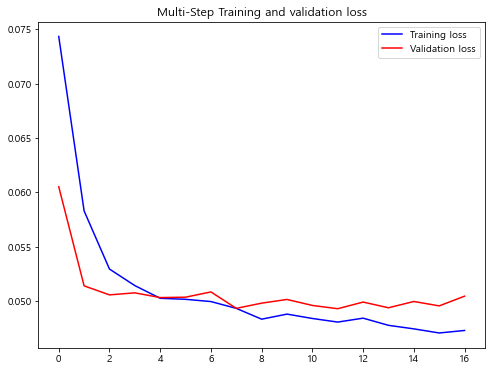

In [120]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(history, 'Multi-Step Training and validation loss')

In [121]:
trainScore = lstmodel.evaluate(x_train, y_train, verbose=0)
print('Train Score: ',trainScore)

valScore = lstmodel.evaluate(x_valid, y_valid, verbose=0)
print('Validation Score: ',valScore)


Train Score:  0.04703214764595032
Validation Score:  0.050424546003341675


### 테스트 해 보기
최신 데이터를 다운로드 하여 input 데이터를 넣어 보고 예측해보기!

In [226]:
test = pd.read_csv('./data/testdata2.csv', encoding='CP949')
display(test)

# 날씨 데이터의 NaN 값을 0으로 바꿔준다.
test=test.fillna(0)

,지점,지점명,일시,평균기온(°C),일강수량(mm)
0,268,진도군,2021-05-06,14.7,NaN
1,268,진도군,2021-05-07,16.6,NaN
2,268,진도군,2021-05-08,15.2,NaN
3,268,진도군,2021-05-09,16.4,NaN
4,268,진도군,2021-05-10,18.2,NaN
5,268,진도군,2021-05-11,19.7,NaN
6,268,진도군,2021-05-12,20.0,NaN
7,268,진도군,2021-05-13,19.0,NaN
8,268,진도군,2021-05-14,20.4,0.0
9,268,진도군,2021-05-15,21.7,20.5


In [227]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

test.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols=['평균기온(°C)','일강수량(mm)']
test_scaled=scaler.fit_transform(test[scale_cols])
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = scale_cols

display(test_scaled)

,평균기온(°C),일강수량(mm)
0,0.000000,0.000000
1,0.240506,0.000000
2,0.063291,0.000000
3,0.215190,0.000000
4,0.443038,0.000000
5,0.632911,0.000000
6,0.670886,0.000000
7,0.544304,0.000000
8,0.721519,0.000000
9,0.886076,0.449561


In [228]:
feature_list = []

for i in range(len(test_scaled) - 20):
    feature_list.append(np.array(test_scaled.iloc[i:i+20]))

test_input = np.array(feature_list)
display(test_input)

array([[[0.        , 0.        ],
        [0.24050633, 0.        ],
        [0.06329114, 0.        ],
        [0.21518987, 0.        ],
        [0.44303797, 0.        ],
        [0.63291139, 0.        ],
        [0.67088608, 0.        ],
        [0.5443038 , 0.        ],
        [0.72151899, 0.        ],
        [0.88607595, 0.4495614 ],
        [0.65822785, 1.        ],
        [0.05063291, 0.01754386],
        [0.18987342, 0.        ],
        [0.59493671, 0.        ],
        [0.18987342, 0.28508772],
        [0.25316456, 0.        ],
        [0.40506329, 0.        ],
        [0.63291139, 0.        ],
        [0.36708861, 0.        ],
        [0.32911392, 0.        ]],

       [[0.24050633, 0.        ],
        [0.06329114, 0.        ],
        [0.21518987, 0.        ],
        [0.44303797, 0.        ],
        [0.63291139, 0.        ],
        [0.67088608, 0.        ],
        [0.5443038 , 0.        ],
        [0.72151899, 0.        ],
        [0.88607595, 0.4495614 ],
        [0.6

In [229]:
test_pred = lstmodel.predict(test_input)
test_pred.shape

(12, 1)

In [230]:
result = scaler1.inverse_transform(test_pred)
print(result)

[[3113.3682]
 [3011.9175]
 [2931.849 ]
 [2751.1165]
 [2661.276 ]
 [2447.0652]
 [2224.4014]
 [2001.2633]
 [1784.2053]
 [2190.358 ]
 [2087.2148]
 [1866.0133]]


In [231]:
flag=False
# 여기로 쿼리를 불러와서 확인하기!
for date in pandas.date_range(start='20210526', end='20210606'):
    # 반복문으로 하세요를레히후!

    # start와 end로 끝나는 반복문에서 입력타입이 String이므로 스트링으로 바꿔준다.
    # 반복문을 date_range로 한 이유는 숫자형으로 하면 20179999이런 식으로 갈 수 있기 때문이다.
    # date1: 오늘, date2: 전날, date3: 전년도 오늘
    date1 = str(date.strftime("%Y%m%d"))
    #print(date1)
    date2 = str((date-timedelta(days=1)).strftime("%Y%m%d"))
    date3 = str((date-timedelta(days=365)).strftime("%Y%m%d"))
    query1=query_sender(date1,
                       date2,
                       date3,
                       '대파')
    #print("쿼리 = \n",query)
    # 함수를 호출한다.
    i_list1=xml_to_item_list(query1, date1)
    #print("i_list = \n", i_list)
    #display("리스트",i_list)

    check = pd.DataFrame(i_list1)
    #df = df.iloc[1:, 1:]

    check=check.drop(check.index[0])
    if not flag:
        flag = True
        col=['날짜', '품목명', '평균가격', '전일평균가격', '전년가격', '등급']
        check.columns=col
        check.to_csv('./data/check.csv',encoding='utf-8-sig')
    else:
        check.to_csv('./data/check.csv',encoding='utf-8-sig',mode='a', header=False)

check = pd.read_csv('./data/check.csv', index_col=0)
display(check)

,날짜,품목명,평균가격,전일평균가격,전년가격,등급
1,20210526,대파(일반),3601,3662,1868,특
2,20210526,대파(일반),2152,2153,1623,상
3,20210526,대파(일반),1572,1676,1496,중
4,20210526,대파(일반),1180,1392,1208,하
1,20210527,대파(일반),3699,3601,1952,특
2,20210527,대파(일반),1554,2152,1639,상
3,20210527,대파(일반),1247,1572,1500,중
4,20210527,대파(일반),1110,1180,1257,하
1,20210528,대파(일반),3755,3699,1992,특
2,20210528,대파(일반),1594,1554,1628,상


In [232]:
print('## groupby (등급) ##')
cgrouped = check.groupby('등급')

#그룹 확인
result_g = cgrouped.get_group(name='특')
result_g['결과'] = result
display(result_g)


## groupby (등급) ##


c:\201814471\setup\envs\py37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,날짜,품목명,평균가격,전일평균가격,전년가격,등급,결과
1,20210526,대파(일반),3601,3662,1868,특,3113.368164
1,20210527,대파(일반),3699,3601,1952,특,3011.917480
1,20210528,대파(일반),3755,3699,1992,특,2931.849121
1,20210529,대파(일반),2317,3755,1769,특,2751.116455
1,20210530,대파(일반),0,2317,1672,특,2661.275879
1,20210531,대파(일반),2202,0,0,특,2447.065186
1,20210601,대파(일반),2892,2202,2044,특,2224.401367
1,20210602,대파(일반),2837,2892,1992,특,2001.263306
1,20210603,대파(일반),2355,2837,1855,특,1784.205322
1,20210604,대파(일반),2268,2355,1865,특,2190.357910
